### Importing Required Libraries

In this section, we import all the necessary libraries for building and training the model. The key libraries include:
- **PyTorch** for deep learning functionality (e.g., tensor operations, neural networks, optimizers).
- **Transformers** from HuggingFace for using pre-trained BERT models.
- **Scikit-learn** for dataset splitting and preprocessing.
- **Matplotlib** for visualizations.
- **TorchVision** for pre-trained models like ResNet for any vision-based tasks.
- **TorchVision** for load and process CSV file

In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import re
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torchvision.models import resnet18, resnet101
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import string


/home/ghufron/miniconda3/envs/homework2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting Random Seeds for Reproducibility

In machine learning, it is important to ensure that experiments are reproducible. This can be achieved by setting a random seed, which ensures that the results of the model are consistent across runs. Here, we define a function `set_seed` that sets the random seed for NumPy, Python’s random library, and PyTorch to ensure reproducibility across all platforms.

The function also handles the CUDA random seed, ensuring that experiments using GPU will have consistent results.

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42) 

### Loading the Dataset

We begin by loading the dataset from a CSV file using **Pandas**. The dataset is located at the specified path and is read into a DataFrame. The DataFrame `df` will hold the data, making it easy to manipulate, preprocess, and analyze.

In [4]:
df = pd.read_csv('/home/ghufron/Downloads/AI_Human/AI_Human.csv')

### Text Cleaning Function

In this section, we define a function `clean_text` to preprocess the text data. The function performs the following operations:
- Converts all text to lowercase to standardize the input.
- Replaces multiple consecutive spaces with a single space.
- Removes punctuation and non-alphanumeric characters to clean the text.
- Strips leading and trailing whitespace.

After defining the function, it is applied to the `text` column of the DataFrame. The `apply` method is used to apply the cleaning function to each row in the `text` column, ensuring that the text data is cleaned consistently.

This step helps prepare the text data for further processing, such as tokenization or feature extraction, by eliminating noise and ensuring uniformity.

In [5]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    return text.strip()

df['text'] = df['text'].astype(str).apply(clean_text)

### Sampling and Shuffling the Dataset

In this step, we first sample a balanced subset of data for both human-generated and AI-generated text:
- **Human data (label=0)**: We select 50,000 random samples from the rows where the `generated` column equals 0.
- **AI data (label=1)**: We similarly select 50,000 random samples from the rows where the `generated` column equals 1.

Once both subsets are created, they are concatenated into a single DataFrame. The `pd.concat` function combines the two subsets along the rows (axis=0), ensuring a balanced dataset with an equal number of human and AI data.

After concatenation, the dataset is shuffled randomly using the `sample(frac=1)` function to ensure that the data is mixed. The `reset_index(drop=True)` ensures that the index is reset after shuffling, making the dataset ready for further processing.

This step ensures that the dataset is balanced and randomized, reducing bias during model training.


In [6]:
human_data = df[df['generated'] == 0].sample(n=150000, random_state=42)  # Sample human data (label=0)
ai_data = df[df['generated'] == 1].sample(n=150000, random_state=42)  # Sample AI data (label=1)

df = pd.concat([human_data, ai_data], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_152650/333406258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


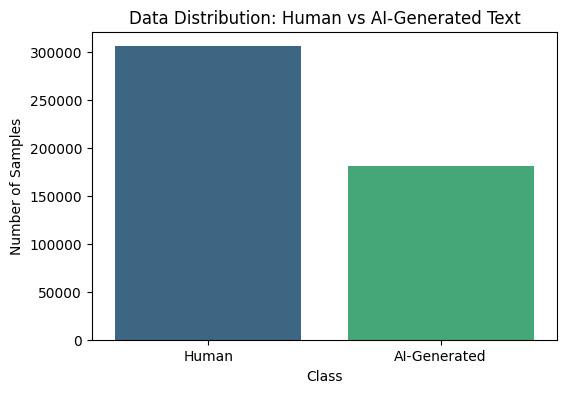

In [143]:
class_counts = df['generated'].value_counts()
class_labels = {0: 'Human', 1: 'AI-Generated'}

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xticks(ticks=[0, 1], labels=[class_labels[0], class_labels[1]])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Data Distribution: Human vs AI-Generated Text')
plt.show()

### Loading the BERT Tokenizer

Here, we load the pre-trained **BERT tokenizer** from HuggingFace's model hub. The tokenizer, `BertTokenizer`, is responsible for converting the raw text into tokenized input that can be fed into the BERT model. We use the `bert-base-uncased` variant, which is a smaller version of the BERT model, pre-trained on a large corpus of text in an uncased format (i.e., it doesn't differentiate between lowercase and uppercase).

This tokenizer will break down the input text into tokens that the BERT model can understand, and it also handles tasks like padding, truncation, and creating attention masks.

By using a pre-trained tokenizer, we ensure that our input data is compatible with the pre-trained BERT model.


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Token Distribution in the Dataset

This section visualizes the distribution of token counts across the texts in the dataset. Tokenization is performed using the BERT tokenizer, and the number of tokens for each text is computed. The histogram below shows the frequency of token counts, along with a Kernel Density Estimate (KDE) curve to smooth the distribution.

#### Key Insights:
- The x-axis represents the number of tokens in each text.
- The y-axis shows the density of token counts, normalizing the raw frequencies.
- The KDE curve provides a smoothed estimate of the token distribution.

This visualization helps in understanding the overall token count spread and whether there are outliers with excessively long texts.


Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


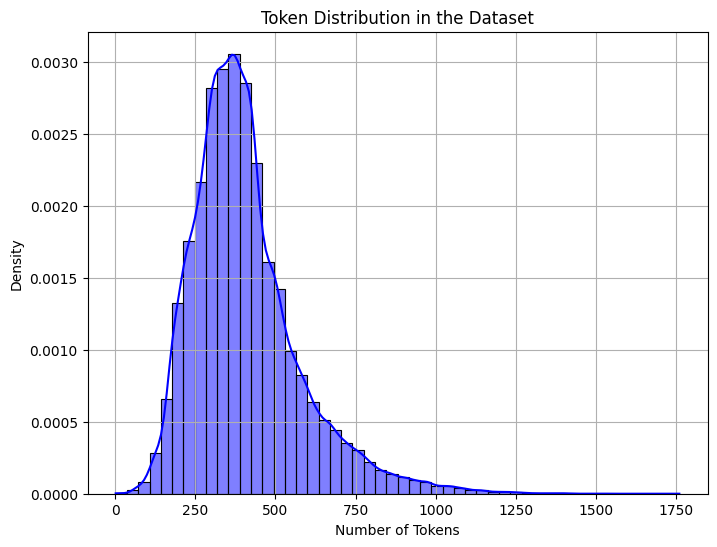

In [8]:
def get_token_counts(texts, tokenizer):
    token_counts = []
    for text in texts:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        token_counts.append(len(tokens))
    return token_counts

token_counts = get_token_counts(df['text'], tokenizer)

# Plot the token distribution
plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=50, kde=True, color='blue', stat='density')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.title('Token Distribution in the Dataset')
plt.grid(True)
plt.show()


### Token Distribution for Human vs AI-Generated Text

This visualization compares the token distribution between human-written texts and AI-generated texts. The number of tokens in each text is computed, and histograms with Kernel Density Estimate (KDE) curves are plotted for both categories.

#### Key Insights:
- **Human Texts**: Represented in blue, showing the distribution of token counts for human-generated content.
- **AI-Generated Texts**: Represented in orange, showing the distribution of token counts for AI-generated content.
- The **x-axis** represents the number of tokens in each text.
- The **y-axis** shows the density, which is a normalized frequency.

This comparison helps in identifying differences in text length and structure between human and AI-generated texts.


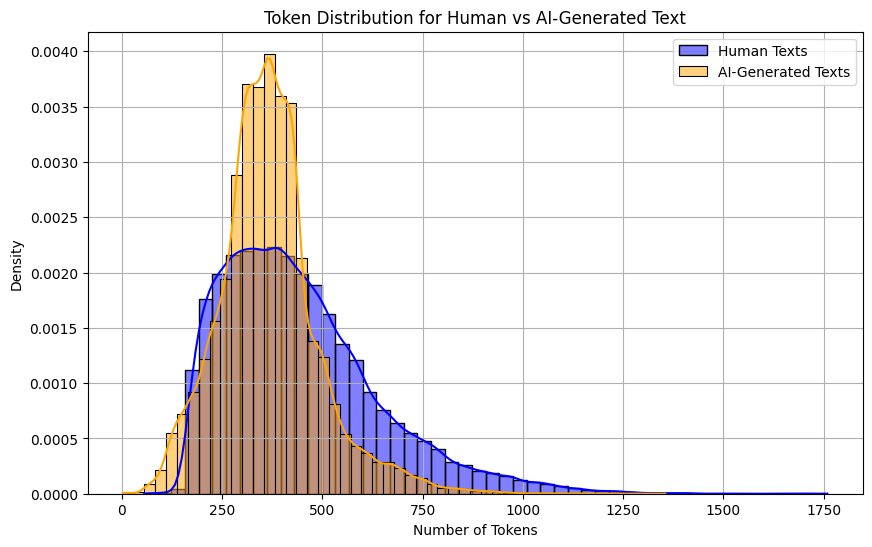

In [ ]:
# Filter human and AI-generated texts
human_texts = df[df['generated'] == 0]['text']
ai_texts = df[df['generated'] == 1]['text']

# Get token counts for both classes
human_token_counts = get_token_counts(human_texts, tokenizer)
ai_token_counts = get_token_counts(ai_texts, tokenizer)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(human_token_counts, bins=50, kde=True, color='blue', label='Human Texts', stat='density')
sns.histplot(ai_token_counts, bins=50, kde=True, color='orange', label='AI-Generated Texts', stat='density')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.title('Token Distribution for Human vs AI-Generated Text')
plt.legend()
plt.grid(True)
plt.show()


### Most Common Tokens for Human vs AI-Generated Texts

This analysis visualizes the most common tokens in human-written and AI-generated texts. The top 10 most frequent tokens for each class are plotted, showing the percentage frequency of each token relative to the total number of tokens in that category.

#### Key Insights:
- **Tokenization**: Text is tokenized using the BERT tokenizer, and the most frequent tokens are identified for both human and AI-generated texts.
- **Bar Plot**: Each bar represents a token's percentage frequency, where the height corresponds to its relative occurrence in the respective text category.
  - **Human Texts**: Represented with **orange** bars.
  - **AI-Generated Texts**: Represented with **royal blue** bars.
- The **x-axis** shows the tokens, and the **y-axis** represents their percentage frequency.

This visualization helps highlight the most distinctive tokens used in each category, providing insight into the linguistic characteristics of human versus AI-generated content.


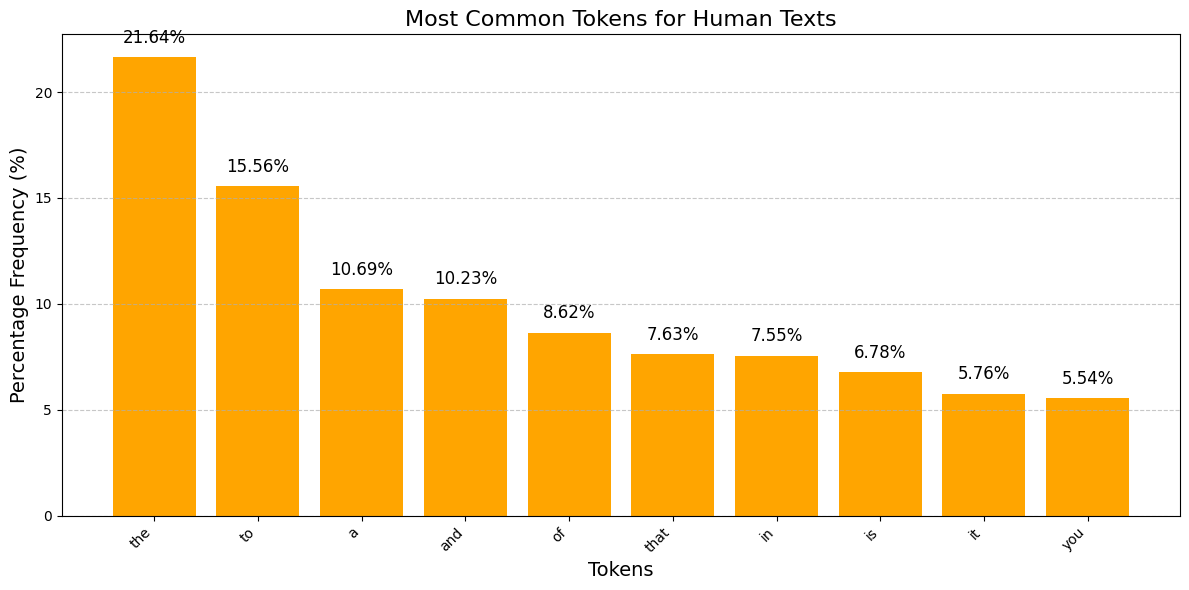

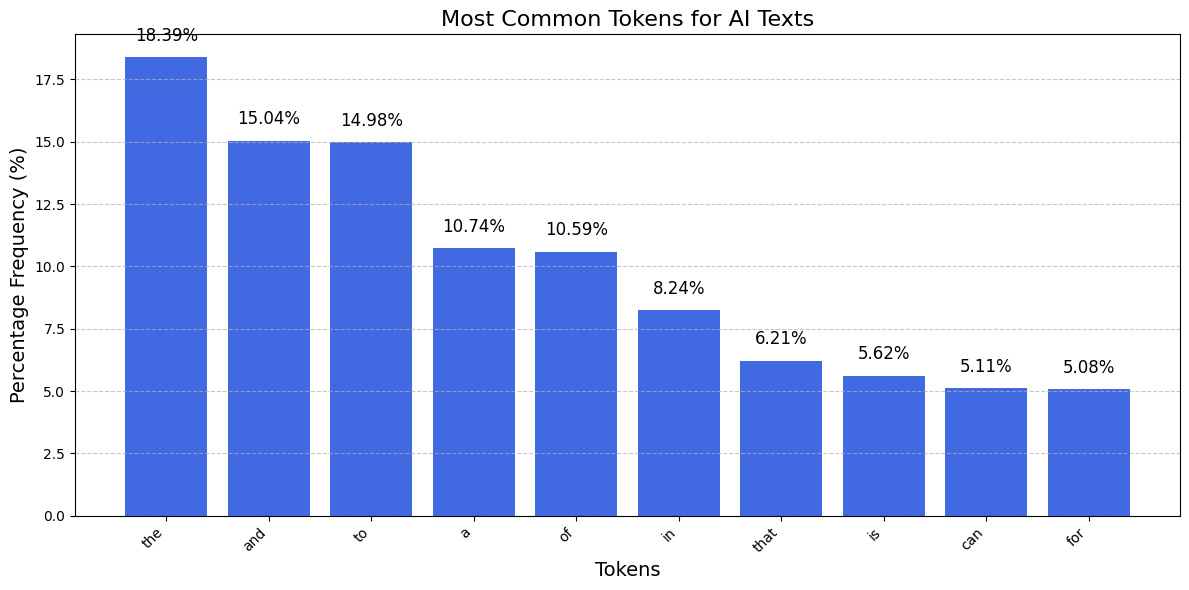

In [ ]:
def plot_common_tokens(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    total_tokens = sum(counts)
    percentages = [(count / total_tokens) * 100 for count in counts]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(tokens, percentages, color='royalblue' if class_value == 1 else 'orange')

    plt.title(f'Most Common Tokens for {class_map[class_value]} Texts', fontsize=16)
    plt.xlabel('Tokens', fontsize=14)
    plt.ylabel('Percentage Frequency (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def tokenize_texts(df, tokenizer):
    df['tokens'] = df['text'].apply(lambda x: tokenizer.tokenize(x))
    return df


df = tokenize_texts(df, tokenizer)
plot_common_tokens(df, 0)  
plot_common_tokens(df, 1)

### Custom Dataset for Text Classification

In this step, we define a custom **TextDataset** class that inherits from PyTorch's `Dataset` to handle the tokenization and preparation of text data for model training.

- The `__init__` method initializes the dataset by taking in the DataFrame, tokenizer, and the maximum sequence length (`max_len`). It stores the relevant columns (`text` and `generated`) and the tokenizer for later use.
- The `__len__` method returns the total number of samples in the dataset, allowing PyTorch's `DataLoader` to know how many batches to process.
- The `__getitem__` method retrieves the text sample at the specified index, applies tokenization using the BERT tokenizer (`encode_plus`), and handles padding and truncation to ensure that all sequences have a fixed length. It also returns:
  - `ids`: The tokenized and padded input sequence.
  - `targets`: The label (human or AI).
  - `text_lengths`: The length of the text before padding, useful for attention masking.

The dataset is created with the specified maximum sequence length (`max_length`), which is determined by the tokenizer’s maximum length limit (`tokenizer.model_max_length`).

This custom dataset ensures that text data is tokenized and padded efficiently, making it ready for input to a BERT model.


In [133]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

max_length = tokenizer.model_max_length
dataset = TextDataset(df, tokenizer, max_length)

### Creating Data Loaders for Training, Validation, and Testing

In this section, we define the function `create_data_loaders`, which splits the dataset into training, validation, and testing sets and creates corresponding data loaders. Here's how it works:
- **Train, Validation, and Test Split**: The dataset is split into three subsets: training, validation, and testing. The function calculates the lengths for each subset and uses `random_split` to create them.
- **Data Loaders**: PyTorch's `DataLoader` is used to load the data for each subset. The training data is shuffled (`shuffle=True`), ensuring that the model doesn't see the same sequence order every epoch. The validation and test data are not shuffled (`shuffle=False`), as the order doesn't matter during evaluation.

The function returns three data loaders:
- **train_loader**: For training the model.
- **val_loader**: For evaluating the model during training.
- **test_loader**: For evaluating the model on the test set after training.

These data loaders provide batches of data, efficiently feeding them to the model during each phase (training, validation, and testing).


In [ ]:
def create_data_loaders(dataset, train_prop=0.75, test_prop=0.1, batch_size=32, valIsEqualTest=True):
    if valIsEqualTest:
        val_prop = 1-train_prop
        train_len = int(train_prop * len(dataset))
        val_len = int(val_prop * len(dataset))

        train_set, val_set = random_split(dataset, [train_len, val_len])

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
        test_loader = val_loader
    else:
        val_prop = 1-train_prop-test_prop
        train_len = int(train_prop * len(dataset))
        val_len = int(val_prop * len(dataset))
        test_len = int(test_prop * len(dataset))

        train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

The **Attention** mechanism and **LSTMClassifier** combine two powerful techniques for sequential data modeling. The attention mechanism enhances the model's ability to focus on the most relevant parts of the input sequence, which is particularly useful when dealing with long sequences. It computes attention weights using a linear transformation, applying a softmax function to highlight important tokens while masking out padding tokens. This allows the model to pay attention to meaningful parts of the text, even if they are distant in the sequence. The masking operation ensures that padding tokens do not contribute to the attention calculation, making the process more efficient. The LSTM, a type of Recurrent Neural Network (RNN), captures long-range dependencies in the sequence, making it ideal for tasks like text classification. LSTMs process input sequences one step at a time, maintaining an internal memory of previous time steps, which helps the model retain contextual information. The attention mechanism is applied to the LSTM outputs, ensuring that the model focuses on the most informative tokens and generating a context vector for final classification. The combination of LSTM and attention results in improved performance, especially for tasks where the context and meaning of specific words are critical. Additionally, dropout is used as a regularization technique to prevent overfitting by randomly deactivating a portion of neurons during training, making the model more robust. This architecture is highly effective for NLP tasks, such as classifying human vs. AI-generated text, by leveraging both sequential learning and the ability to focus on the most relevant information in the input sequence.

In [136]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, outputs, mask):
        # outputs: (batch_size, seq_len, hidden_dim)
        # mask: (batch_size, seq_len), 1 where real tokens, 0 where padding
        attn_weights = self.attn(outputs).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = attn_weights.masked_fill(mask == 0, -1e9)  # mask out padding
        attn_weights = torch.softmax(attn_weights, dim=1)  # (batch_size, seq_len)

        # context: (batch_size, hidden_dim)
        context = torch.bmm(attn_weights.unsqueeze(1), outputs).squeeze(1)
        return context


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx=0):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, input_lengths):
        # input_ids: (batch_size, seq_len)
        mask = (input_ids != 0).int()  # 1 where token, 0 where padding

        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embed_dim)

        packed = pack_padded_sequence(embedded, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)

        # Ensure output has original sequence length for masking
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=input_ids.size(1))

        # Apply attention
        context = self.attention(output, mask)

        out = self.dropout(context)
        out = self.fc(out).squeeze(1)  # (batch_size)

        return out

### Setting the Device for Model Training

In this step, we determine whether a **GPU** (CUDA-enabled device) is available for model training. If a GPU is available, the model will be moved to the GPU for faster computation; otherwise, it will default to using the **CPU**. This is done by checking if `torch.cuda.is_available()` returns `True`. The device is stored in the variable `device`, which can later be used to move tensors and models to the appropriate device. The available device is printed for confirmation, ensuring that the model is using the optimal hardware for training.

This approach helps ensure that the code runs efficiently by utilizing GPU acceleration when possible, especially for large-scale deep learning tasks.


In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available Device: {device}')

Available Device: cuda


### Model Initialization

In this step, the vocabulary size (`vocab_size`) is obtained from the tokenizer, which represents the total number of unique tokens in the model's vocabulary. This is important because it defines the size of the embedding layer, which maps input tokens to dense vector representations.

The model's hyperparameters are then set:
- **Embedding Dimension** (`embedding_dim`): Defines the size of the dense vector for each token in the vocabulary. This helps capture the semantic meaning of words.
- **Hidden Dimension** (`dimension`): Specifies the size of the hidden states in the LSTM layer, which determines the model's ability to capture sequential dependencies.

After these parameters are set, the `LSTMClassifier` model is instantiated with the vocabulary size, embedding dimension, and hidden dimension. This model is now ready for training or evaluation.

The print statement confirms the vocabulary size, which is a key parameter for initializing the embedding layer and ensuring the model is correctly set up.


In [138]:
vocab_size = len(tokenizer.vocab)
dimension = 128
embedding_dim = 100

print(f'Vocab size: {vocab_size}')
model = LSTMClassifier(vocab_size, embedding_dim, dimension)

Vocab size: 30522


### Training and Evaluation Function

The `train_model` function is responsible for training and evaluating the model over multiple epochs. Here's a breakdown of how the function operates:

- **Training Loop**:
  - The model is set to training mode (`model.train()`), and a loop is run for the specified number of epochs.
  - During each epoch, the model processes batches of data from the training loader:
    - The `optimizer.zero_grad()` resets the gradients from the previous step.
    - The data is sorted by sequence length (to handle padding) using `text_lengths.sort()`.
    - The inputs (`ids`) and targets are moved to the appropriate device (GPU or CPU).
    - The model's predictions are computed by passing the input through the model.
    - The loss is calculated using the given criterion (loss function), and gradients are backpropagated with `loss.backward()`.
    - The optimizer updates the model's parameters with `optimizer.step()`.
  - The average training loss for the epoch is computed and printed.

- **Validation Loop**:
  - After the training step, the model is set to evaluation mode (`model.eval()`).
  - The validation loss and accuracy are computed using the validation loader:
    - No gradients are calculated during validation (using `torch.no_grad()`).
    - The loss is accumulated across all batches, and predictions are compared to the true targets to compute accuracy.
    - The model's performance is measured in terms of both loss and accuracy, and these metrics are printed.

- **Model Saving**:
  - After completing all epochs, the model's state dictionary (weights) is saved to a file, which allows the model to be reloaded later for inference or further training.

- **Plotting**:
  - The training and validation loss curves are plotted over the epochs, providing insight into how the model is learning.
  - The validation accuracy curve is also plotted to show how well the model generalizes to unseen data.

This function is essential for both monitoring the model's performance during training and ensuring it is properly saved for later use.


In [139]:
def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path='model.pth'):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()

        epoch_train_loss = 0
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            targets = targets.to(device).float()

            predictions = model(ids, text_lengths)

            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"  >> Average Training Loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            total_loss = 0
            total_correct = 0
            total_labels = 0

            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device).float()

                predictions = model(ids, text_lengths)
                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)

                probs = torch.sigmoid(predictions)
                preds = (probs > 0.5).long()

                total_correct += (preds == targets.long()).sum().item()
                total_labels += ids.size(0)

            avg_val_loss = total_loss / total_labels
            avg_val_acc = total_correct / total_labels

            val_losses.append(avg_val_loss)
            val_accuracies.append(avg_val_acc)

            print(f"  >> Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), save_path)
    print(f"\nModel saved to {save_path}")

    # Plot Loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curve.png")
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_curve.png")
    plt.show()

    return train_losses, val_losses, val_accuracies


### Setting Loss Function and Optimizer

In this section, the model is configured with a loss function and optimizer before starting the training process:

- **Loss Function**: 
  - The loss function used is **Binary Cross Entropy with Logits Loss** (`BCEWithLogitsLoss`). This is suitable for binary classification tasks like distinguishing between human and AI-generated text. It combines a sigmoid activation and binary cross-entropy loss into one function.
  - **Positional Weight**: To address class imbalance (with the number of human samples being larger than AI-generated samples), a **positional weight** is computed as the ratio of the number of human data points to AI data points. This ensures that the model places more importance on correctly classifying the minority class (AI-generated text). The computed weight is transferred to the device (GPU or CPU).

- **Optimizer**: 
  - The **Adam optimizer** is used, which is well-suited for training deep learning models due to its adaptive learning rates and efficient gradient computation. It updates the model parameters based on the computed gradients.

- **Model and Loss Function to Device**:
  - The model and loss function are moved to the chosen device (GPU or CPU), ensuring the computations are performed on the correct hardware.

- **Training**:
  - The model is then trained for a specified number of epochs (in this case, 10). The `train_model` function is called with the training and validation data loaders, model, loss function, optimizer, and device.

This configuration sets up the model to handle class imbalance and optimize its parameters effectively, followed by running the training process.



Epoch 1/10
  >> Average Training Loss: 0.0492
  >> Validation Loss: 0.0144, Validation Accuracy: 0.9956

Epoch 2/10
  >> Average Training Loss: 0.0096
  >> Validation Loss: 0.0073, Validation Accuracy: 0.9977

Epoch 3/10
  >> Average Training Loss: 0.0043
  >> Validation Loss: 0.0063, Validation Accuracy: 0.9983

Epoch 4/10
  >> Average Training Loss: 0.0027
  >> Validation Loss: 0.0040, Validation Accuracy: 0.9987

Epoch 5/10
  >> Average Training Loss: 0.0018
  >> Validation Loss: 0.0044, Validation Accuracy: 0.9987

Epoch 6/10
  >> Average Training Loss: 0.0015
  >> Validation Loss: 0.0040, Validation Accuracy: 0.9987

Epoch 7/10
  >> Average Training Loss: 0.0010
  >> Validation Loss: 0.0039, Validation Accuracy: 0.9988

Epoch 8/10
  >> Average Training Loss: 0.0009
  >> Validation Loss: 0.0037, Validation Accuracy: 0.9989

Epoch 9/10
  >> Average Training Loss: 0.0006
  >> Validation Loss: 0.0044, Validation Accuracy: 0.9990

Epoch 10/10
  >> Average Training Loss: 0.0006
  >> Va

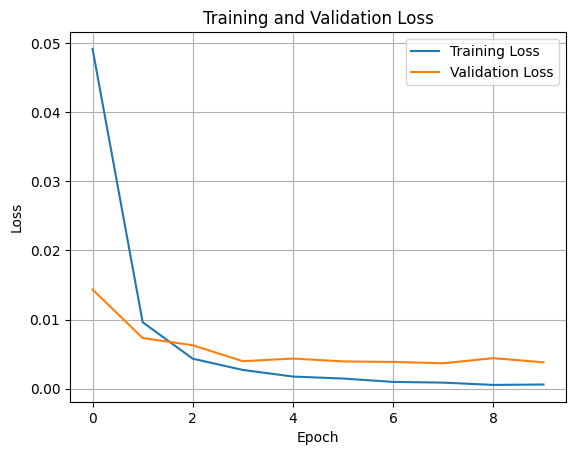

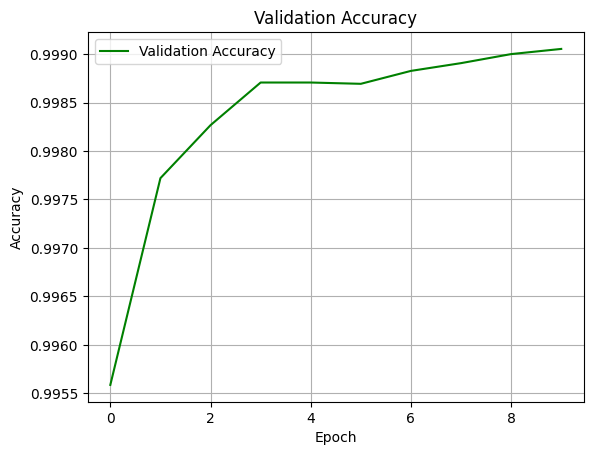

In [140]:
pos_weight_val = len(human_data) / len(ai_data)
pos_weight = torch.tensor([pos_weight_val]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

epochs = 10
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

### Conclusion

In conclusion, the model leverages a combination of **LSTM** and **Attention** mechanisms for effective text classification, particularly distinguishing between human and AI-generated content. The **LSTM** captures sequential dependencies in text data, while the **Attention** mechanism allows the model to focus on important tokens, improving its ability to handle long sequences and reducing the impact of irrelevant padding. The model is trained using **Binary Cross-Entropy with Logits Loss**, which accounts for class imbalance through the use of a positional weight, and optimized with the **Adam optimizer** for efficient parameter updates. The training process involves multiple epochs, with periodic evaluations on the validation set to track performance. After training, the model is saved, and training/validation losses and accuracies are plotted for analysis. This setup ensures a well-rounded approach to handling text data, focusing on important parts of the sequence, managing class imbalance, and optimizing performance across training and validation.

### Key Points:
- **LSTM** and **Attention** mechanisms for sequential data modeling and focusing on relevant tokens.
- **BCEWithLogitsLoss** with positional weighting to address class imbalance.
- **Adam optimizer** for efficient parameter updates.
- Model trained and evaluated over multiple epochs.
- Training and validation performance tracked and visualized.
- Model saved for future use or further training.
